In [1]:
#import user modules
#--- MATPLOTLIB
import matplotlib.pyplot as plt
import matplotlib
from matplotlib.markers import MarkerStyle
from matplotlib.gridspec import GridSpec
import matplotlib.colors as mcolors
import seaborn as sns
import pandas as pd

import sys
my_path = "../../Python/"
if my_path not in sys.path:
    sys.path.append(my_path)
 
for place in sys.path: 
    print(place)

import costfun.costfun as cost
import utils.figures as fig_help

import importlib as imp
def reload_modules():
    imp.reload(cost)
    imp.reload(fig_help)

import itertools
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'
latex_engine = 'xelatex'
latex_elements = {'preamble':r'\usepackage{physics}'}

%matplotlib inline
colors_ls = (list(mcolors.TABLEAU_COLORS)[:120])
colors_ls_cyc = itertools.cycle(colors_ls)
markers_ls = ['o','s','v', 'D', '<', 'X', '^', '*', '+']
markers = itertools.cycle(markers_ls)

#--- NUMERICAL LIBS
import numpy as np
import itertools
import math
import random
from cmath import nan
import h5py   


# SCIPY LIBS
import scipy.stats as statistics
from scipy.special import binom
from scipy.special import erfinv
from scipy.special import digamma
from scipy.special import polygamma
from scipy.special import lambertw
from scipy.optimize import curve_fit as fit
from scipy.signal import savgol_filter
from scipy import integrate
from scipy import fft
 
# OTHER
import warnings
warnings.filterwarnings('ignore')
from joblib import Parallel, delayed
import copy
import os
from os import sep as kPSep
from os.path import exists

base_dir = "../results/"


/Users/rafal.swietek/Projects/QHamSolver/QuantumSun/Jupyter_Python
/Users/rafal.swietek/opt/anaconda3/lib/python39.zip
/Users/rafal.swietek/opt/anaconda3/lib/python3.9
/Users/rafal.swietek/opt/anaconda3/lib/python3.9/lib-dynload

/Users/rafal.swietek/opt/anaconda3/lib/python3.9/site-packages
/Users/rafal.swietek/opt/anaconda3/lib/python3.9/site-packages/aeosa
/Users/rafal.swietek/opt/anaconda3/lib/python3.9/site-packages/locket-0.2.1-py3.9.egg
/Users/rafal.swietek/opt/anaconda3/lib/python3.9/site-packages/IPython/extensions
/Users/rafal.swietek/.ipython
../../Python/


In [15]:
def order_of_magnitude2(a_value):
    #return 2
    if np.abs(a_value) < 1.0 and a_value != 0:
        m = np.abs(np.log10(np.abs(a_value)))
        return int(max(math.ceil(m) + 1., 2.))
    else: 
        return 2

def order_of_magnitude(a_value):
    a_value = np.round(a_value, 12)
    num_str = f"{a_value - int(a_value)}"
    num_str = num_str[2:]
    _size = len(num_str)
    if num_str == "0":
        _size = 0;
    
    return _size
    
def info_raw(L, N, J, gamma, zeta, alfa, h, w, ini_ave = 0, use_old = False):
    arr = [J, gamma, zeta, alfa, h, w] if alfa < 1.0 else [J, gamma, alfa, h, w]
    names = ['J', 'g', 'zeta', 'alfa', 'h', 'w'] if alfa < 1.0 else ['J', 'g', 'alfa', 'h', 'w']
    info = "_L=%d,N=%d"%(L,N)
    for i, var in enumerate(arr):
        n = order_of_magnitude2(var) if use_old else order_of_magnitude(var)
        info += str(",%s={:.%df}"%(names[i], n)).format(round(var, n))
    if ini_ave: info += ",ini_ave"
    return info

def info(L, N, J, gamma, zeta, alfa, h, w, ini_ave = 0, use_old = False, ext = '.dat'):
    return info_raw(L, N, J, gamma, zeta, alfa, h, w, ini_ave, use_old) + ext


def GOE(x : np.array):
    """
    GOE shape of sff in thermodynamic limit
    
    Parameters:
    -----------------
        x : np.array
            numpy array with datapoints (times defined for unfolded data)
    """
    return np.array([2 * a - a * np.log(1 + 2 * a) if a < 1 else 2 - a * np.log( (2 * a + 1) / (2 * a - 1) ) for a in x])

def remove_fluctuations(data, bucket_size=10):
    new_data = data;
    half_bucket = int(bucket_size / 2)
    for k in range(half_bucket, len(data) - half_bucket):
        average = np.sum(data[k - half_bucket : k + half_bucket])
        new_data[k - half_bucket] = average / bucket_size
    return new_data

dir_E = base_dir + 'DIAGONALIZATION/'

## SPECTRAL FORM FACTOR

[ 2.   2.5  3.   3.5  4.   4.5  5.   5.5  6.   6.5  7.   7.5  8.   8.5
  9.   9.5 10.  10.5 11.  11.5 12.  12.5 13.  13.5 14.  14.5 15.  15.5
 16.  16.5 17.  17.5 18.  18.5 19.  19.5 20. ]


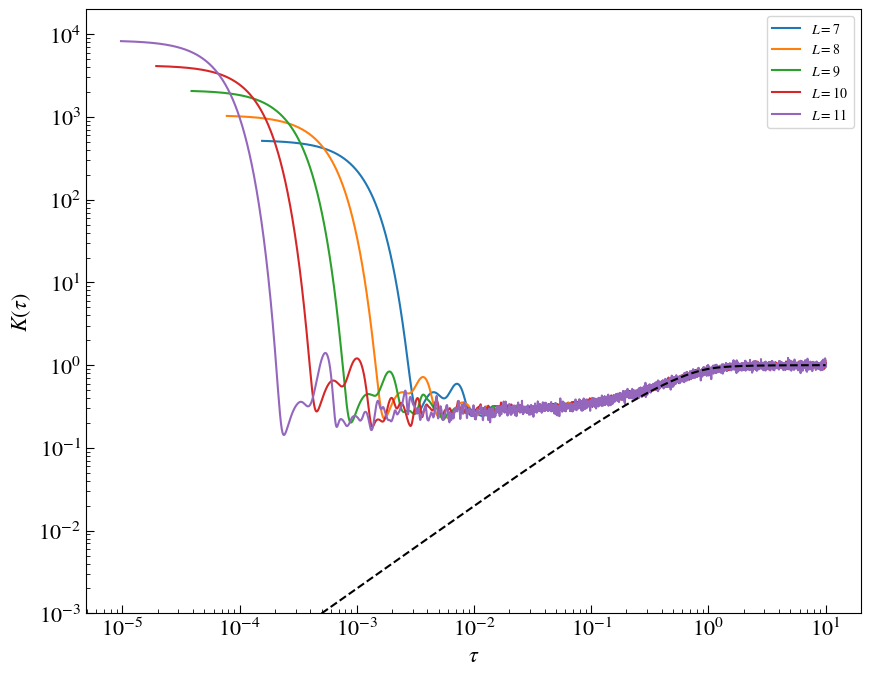

In [23]:
L=11
J=1.0
alfa=0.75
h=1.0
w=0.5
zeta=0.2
N=3
gamma=1.0
ini_ave=1

fig, axis = plt.subplots( nrows=1, ncols=1, figsize=(10,8), dpi = 100)

FOLDED = False

alfa_vals = np.linspace(0.63, 0.78, 16)
w_vals = np.linspace(2.0, 14.5, 26)
w_vals = np.linspace(2.0, 20.0, 37)
print(w_vals)
sizes = np.arange(7, 12, 1)
times = [1]
for L in sizes:
#for alfa in alfa_vals:
#for w in w_vals:
    filename = base_dir + "SpectralFormFactor/" + ("folded" if FOLDED else "") + info(L, N, J, gamma, zeta, alfa, h, w, ini_ave)
    #if not exists(filename):
    #    filename = base_dir + "SpectralFormFactor/" + ("folded" if FOLDED else "") + info(L, M, J, gamma, zeta, alfa, h, w, ini_ave, use_old=True)
    if exists(filename):
        data = pd.read_table(filename, sep="\t", header=None)
        times = np.array(data[0])
        sff = np.array(data[1])
        #sff = remove_fluctuations(sff, int(0.005 * len(sff)))
        tH = data[2][0]
        gap_ratio = data[4][0]
        axis.plot(times, sff, lw=1.5, label=r"$L=%d$"%L)
    else:
        print(filename)

axis.plot(times, GOE(times), ls='--', color='black')
#axis.axhline(y=0.38, ls=':', lw=2, color='black')
axis.legend()
axis.set_ylim(1e-3, 2e4)
axis.set_xscale('log')
axis.set_yscale('log')
axis.set_ylabel(r"$K(\tau)$", fontsize=16)
axis.set_xlabel(r"$\tau$", fontsize=16)
axis.tick_params(axis='both', which='major', direction="in",length=6, labelsize=16)#, length=font_size-4, width=0.05*font_size)
axis.tick_params(axis='both', which='minor', direction="in",length=3, labelsize=16)#, length=0.2*(font_size-4), width=0.05*font_size)
#axis.set_ylim(0, 1.1)

In [19]:
epsilon=8e-2

def get_points(L, gamma):
    w_L = []
    tau_L = []
    tH_L = []
    gaps_L = []
    for alfa in alfa_vals:
    # w_vals = np.linspace(2.0, 20.0, 37)
    # for w in w_vals:
    
        filename = base_dir + "SpectralFormFactor/" + ("folded" if FOLDED else "") + info(L, N, J, gamma, zeta, alfa, h, w, ini_ave)
        if exists(filename):
            w_L.append(alfa)
            data = pd.read_table(filename, sep="\t", header=None)
            times = np.array(data[0])
            sff = np.array(data[1])
            sff = remove_fluctuations(sff, int(0.01 * len(sff)))
            tH = data[2][0]
            gap_ratio = data[4][0]
            times_for_algorithm = times / tH if FOLDED else times
            sff_dev = np.abs(np.log10(sff / GOE(times_for_algorithm)))
            tau = np.nan
            for i, K in reversed(list(enumerate(sff_dev))):
                if K > epsilon and times[i] < (3 * tH if FOLDED else 3):
                    tau = times[i-1]
                    break
            tau_L.append(tau)
            tH_L.append(tH)
            gaps_L.append(gap_ratio)
            
        else:
            print(filename)
    
    return np.array(w_L), np.array(gaps_L), np.array(tau_L), np.array(tH_L)

[ 2.   2.5  3.   3.5  4.   4.5  5.   5.5  6.   6.5  7.   7.5  8.   8.5
  9.   9.5 10.  10.5 11.  11.5 12.  12.5 13.  13.5 14.  14.5 15.  15.5
 16.  16.5 17.  17.5 18.  18.5 19.  19.5 20. ]


No handles with labels found to put in legend.


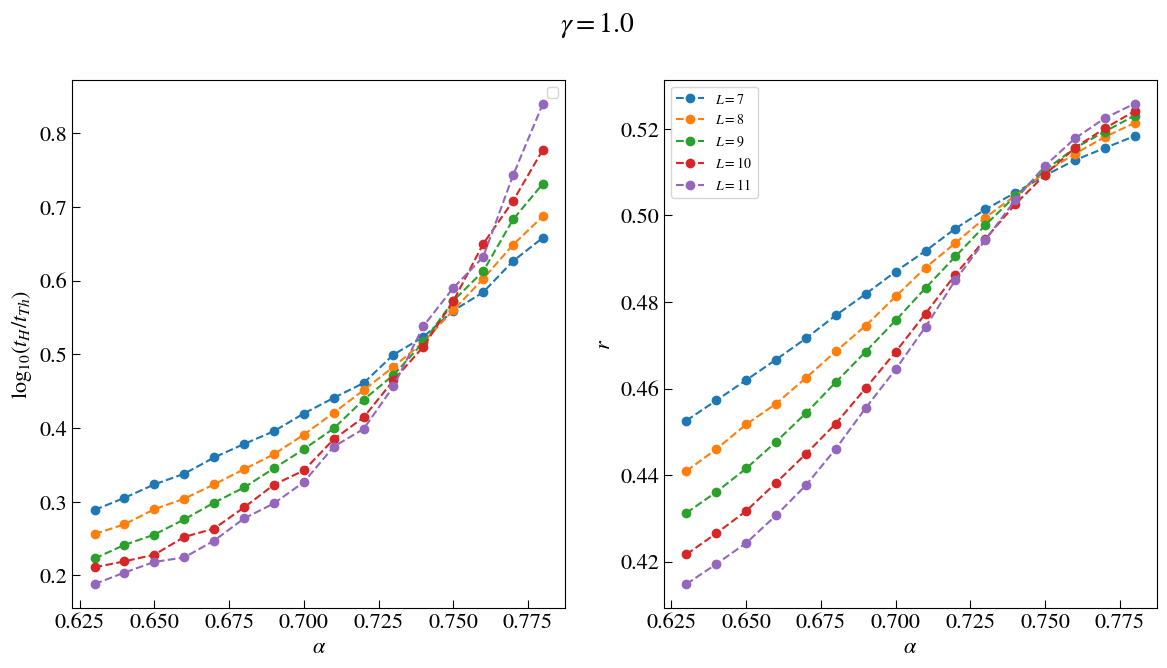

In [24]:
reload_modules()

FOLDED = False
L=11
J=1.0
alfa=1.00
h=1.0
w=0.5
zeta=0.2
N=3
gamma=2.0
ini_ave=1

COLLAPSE = 0
gamma_vals = np.linspace(1.0, 4.0, 13)
gamma_vals = [1.0]
for gamma in gamma_vals:
    fig, axis = plt.subplots( nrows=1, ncols=2, figsize=(14,7), dpi = 100)

    taus = []
    gaps = []
    heisenberg_time = []
    times = [1]
    #w_vals = np.linspace(0.2, 4.0, 20)
    print(w_vals)
    sizes = np.arange(7,12)
    w_plot = []
    for L in sizes:
        w_L, gaps_L, tau_L, tH_L = get_points(L, gamma)

        w_plot.append(np.array(w_L))

        taus.append(np.array(tau_L))
        heisenberg_time.append(np.array(tH_L))
        gaps.append(gaps_L)
        

    gaps = np.array(gaps)
    taus = np.array(taus)
    w_plot = np.array(w_plot)

    if COLLAPSE:
        idx = 0
        xdata = [wx[idx:] for wx in w_plot]
        ydata = [r[idx:] for r in gaps]
        par1, crit_pars1, costfun, status = cost.get_crit_points(x=np.array(xdata), y=np.array(ydata), vals=sizes, crit_fun='lin', scaling_ansatz='KT', seed=412438923)
        print(par1, crit_pars1)

        #ydata = [tTh[idx:] for tTh in np.log10(1.0 / taus)]
        par2, crit_pars2, costfun, status = cost.get_crit_points(x=np.array(xdata), y=np.array(ydata), vals=sizes, crit_fun='lin', scaling_ansatz='KT', seed=412438923)
        print(par2, crit_pars2)

        rescale_fun = cost.resc_functions_dict['KT']
        critical_fun = cost.crit_functions_dict['lin']
        xlab = cost.scale_ansatz_label['KT']('W')
        for ii, L in enumerate(sizes):
            g_cond = np.log10(1.0 / taus[ii])
            axis[0].plot(rescale_fun(w_plot[ii], L, critical_fun, par1, *crit_pars1), g_cond, ls='--', marker='o')
            axis[1].plot(rescale_fun(w_plot[ii], L, critical_fun, par2, *crit_pars2), gaps[ii], ls='--', marker='o', label=r"$L=%d$"%(L))
    else:
        for ii, L in enumerate(sizes):
            g_cond = np.log10(1.0 / taus[ii])
            axis[0].plot(w_plot[ii], g_cond, ls='--', marker='o')
            axis[1].plot(w_plot[ii], gaps[ii], ls='--', marker='o', label=r"$L=%d$"%(L))

    #axis.plot(times, GOE(times), ls='--', color='black')
    axis[0].set_ylabel(r"$\log_{10}(t_H/t_{Th})$", fontsize=16)
    axis[1].set_ylabel(r"$r$", fontsize=16)
    for ax in axis:
        if COLLAPSE: ax.set_xlabel(f"${xlab}$", fontsize=16)
        else: ax.set_xlabel(r"$\alpha$", fontsize=16)
        
        ax.set_xscale('linear')
        ax.set_yscale('linear')
        ax.tick_params(axis='both', which='major', direction="in",length=6, labelsize=16)#, length=font_size-4, width=0.05*font_size)
        ax.tick_params(axis='both', which='minor', direction="in",length=3, labelsize=16)#, length=0.2*(font_size-4), width=0.05*font_size)
        ax.legend()
        #ax.axvline(x=1.0, ls='--', color='black')
        #ax.set_xlim(0.5, 1.5)
    fig.suptitle(f"$\gamma={gamma}$", fontsize=20)
    #axis.set_ylim(0, 1.1)
    #axis[1].set_xlim(0,7)
    # with open(f'results/disorder_gamma={gamma},N={N},alfa={alfa},zeta={zeta},ini_ave={ini_ave}_L=10_14.npy', 'wb') as file: np.save(file, np.array(w_plot), allow_pickle=True)
    # with open(f'results/gap_ratio_gamma={gamma},N={N},alfa={alfa},zeta={zeta},ini_ave={ini_ave}_L=10_14.npy', 'wb') as file: np.save(file, np.array(gaps), allow_pickle=True)
    # with open(f'results/thouless_gamma={gamma},N={N},alfa={alfa},zeta={zeta},ini_ave={ini_ave}_L=10_14.npy', 'wb') as file: np.save(file, np.array(taus), allow_pickle=True)
    # plt.savefig(f"plots/GapRatio_rescaled_gamma={gamma}_alfa={alfa}_ini_ave={ini_ave}.pdf", bbox_inches = 'tight', pad_inches=0.02)
    # plt.savefig(f"plots/GapRatio_rescaled_gamma={gamma}_alfa={alfa}_ini_ave={ini_ave}.png", bbox_inches = 'tight', pad_inches=0.02)

## ENTROPY

In [30]:
L=8
J=1.0
alfa=1.0
h=0.0
w=2.0
zeta=0.0
N=3
gamma=1.5
ini_ave=0

num_realis = 200

dim = 2**(L+N)

for gamma in [1.0, 1.5, 2.0]:
    for w in np.linspace(2.0, 20.0, 37):
        E = np.zeros((dim))
        S = np.zeros((L+1, dim))
        ratio = np.zeros((dim-2))
        counter = 0
        for real in range(num_realis):
            name = base_dir + 'Entropy/Eigenstate/realisation=%d/'%real + info(L=L, N=N, J=J, gamma=gamma, zeta=zeta, alfa=alfa, h=h, w=w, ext='.hdf5')
            #print(name)
            if exists(name):
                counter += 1
                with h5py.File(name, "r") as file:
                    energies = np.array(file.get('energies')[0])
                    entropies = np.array(file.get('entropy'))
                    
                    E += energies
                    S += entropies
                    
                    gaps = np.diff(energies)
                    ratio += np.minimum(gaps[:-1], gaps[1:]) / np.maximum(gaps[:-1], gaps[1:])

        if counter > 0:
            name = base_dir + 'Entropy/Eigenstate/' + info(L=L, N=N, J=J, gamma=gamma, zeta=zeta, alfa=alfa, h=h, w=w, ext='.hdf5')

            hf = h5py.File(name, 'w')
            hf.create_dataset('energies',(dim,), data = E / counter)
            hf.create_dataset('entropies',(L+1,dim), data = S / counter)
            hf.create_dataset('gap ratio',(dim-2,), data = ratio / counter)

            hf.close()